In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pickle as pickle
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.parametric_coupling as pmc
import analysis.plotting as plotting
import analysis.analysis as analysis

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

Qubit(ge_time=67.19789394714729, ro_amp=1, qubit_thr=[-10000, -600], ef_ssm=-0.259, ge_amp=0.5, IQ_angle=205, RO_LO=6.6247, ef_time=74.1982640369346, RO_LO_pwr=16, ge_ssm=-0.114, ef_amp=0.5, RO_IF=None, qubit_id=q1, ROIF=0.10275000000000034, ro_dur=4000, ro_freq=6.72745)
Qubit(ge_time=45.047198597262124, ro_amp=1.5, qubit_thr=[-10000, 1900], ef_ssm=-0.2962, ge_amp=0.5, IQ_angle=85, RO_LO=6.6247, ef_time=None, RO_LO_pwr=16, ge_ssm=-0.154, ef_amp=1, RO_IF=None, qubit_id=q2, ROIF=0.030899999999999928, ro_dur=4000, ro_freq=6.6556)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [22]:
def swap_gate_sweep(freq_list, reps,sweep_time, filename="swap_gate_sweep.pkl"):
    """
    Run a swap gate sweep by performing parametric coupling experiments at each frequency.
    Save results to a file after each step. If the file already exists, restart from the last completed step.
    """
    num_steps = 51  # Number of time steps for the parametric coupling experiment

    # Initialize arrays to store results
    I1_data = np.zeros((len(freq_list),  num_steps))
    Q1_data = np.zeros((len(freq_list), num_steps))
    I2_data = np.zeros((len(freq_list),  num_steps))
    Q2_data = np.zeros((len(freq_list), num_steps))

    # Check if the file exists
    if os.path.exists(filename):
        print(f"Loading existing data from {filename}...")
        with open(filename, "rb") as f:
            saved_data = pickle.load(f)

        # Load saved data
        I1_data = saved_data["I1_data"]
        Q1_data = saved_data["Q1_data"]
        I2_data = saved_data["I2_data"]
        Q2_data = saved_data["Q2_data"]
        last_completed_step = saved_data["last_completed_step"]

        print(f"Resuming from step {last_completed_step + 1}/{len(freq_list)}")
    else:
        last_completed_step = -1  # Start from the beginning

    # Run the sweep
    for i in range(last_completed_step + 1, len(freq_list)):
        frequency = freq_list[i]

        # Perform parametric coupling experiment
        pmc.parametric_coupling_time_domain(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            ssm_para=frequency,
            spec_amp=1.5,
            sweep_time=sweep_time,
            verbose=False,
        )
        wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
        # Acquire the raw IQ data
        values = daq.run_daq_het_2q(
            q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
        )

        # Retrieve raw IQ data from the acquired values
        # I1_raw = values.rec_readout_1[0][:reps * num_steps]
        # Q1_raw = values.rec_readout_1[1][:reps * num_steps]
        # I2_raw = values.rec_readout_2[0][:reps * num_steps]
        # Q2_raw = values.rec_readout_2[1][:reps * num_steps]
        I1_raw = values.rec_avg_vs_pats_1[0]
        Q1_raw = values.rec_avg_vs_pats_1[1]
        I2_raw = values.rec_avg_vs_pats_2[0]
        Q2_raw = values.rec_avg_vs_pats_2[1]

        # Store results
        I1_data[i] = I1_raw
        Q1_data[i] = Q1_raw
        I2_data[i] = I2_raw
        Q2_data[i] = Q2_raw

        # Save results to file after each step
        with open(filename, "wb") as f: 
            pickle.dump(
                {
                    "freq_list": freq_list,
                    "I1_data": I1_data,
                    "Q1_data": Q1_data,
                    "I2_data": I2_data,
                    "Q2_data": Q2_data,
                    "last_completed_step": i,  # Track the last completed step
                },
                f,
            )

        print(f"------------- Done with {i+1}/{len(freq_list)} --------------------")

    return I1_data, Q1_data, I2_data, Q2_data

In [26]:
last_swap_freq=-.021
freq_list = np.linspace(-0.017, -0.021, 21)
sweep_time = 500
swap_gate_sweep(freq_list, reps = 1000, sweep_time = sweep_time)

Loading existing data from swap_gate_sweep.pkl...
Resuming from step 8/21
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 1000
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.437678 sec
Captured 17 buffers (2.640704 buffers per sec)
Captured 52224 records (8112.241888 records per sec)
Transferred 855638016 bytes (132910971.094388 bytes per sec)
------------- Done with 9/21 --------------------
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\

(array([[-3032.50344196, -3123.71187785, -3024.45545215, ...,
         -3546.17204367, -3577.89856   , -3520.86684628],
        [-2873.86950625, -2894.4603002 , -3009.68706672, ...,
         -3465.19571266, -3555.05850807, -3435.7048837 ],
        [-2887.0308386 , -3342.82798402, -3427.28458595, ...,
         -3687.66437812, -3675.77032432, -3644.46016672],
        ...,
        [-2789.3191027 , -2943.13612744, -2968.40148193, ...,
         -3599.98703824, -3560.11380861, -3406.85149062],
        [-2956.49176072, -2895.13740568, -3106.57314626, ...,
         -3508.02288565, -3504.71616938, -3475.53088422],
        [-3037.81678024, -2993.11929474, -2919.80098894, ...,
         -3427.44148773, -3499.30899404, -3263.03326381]]),
 array([[659.61047306, 667.84248771, 659.80132356, ..., 370.37966858,
         456.90833185, 378.81254683],
        [683.92162214, 770.48112943, 807.50905154, ..., 409.35578446,
         368.36406213, 439.0362038 ],
        [912.91051943, 438.77910732, 381.28605965

In [28]:
  # Check if the file exists
filename = 'swap_gate_sweep.pkl'
if os.path.exists(filename):
    print(f"Loading existing data from {filename}")
    with open(filename, "rb") as f:
        saved_data = pickle.load(f)

    # Load saved data
    I1_data = saved_data["I1_data"]
    Q1_data = saved_data["Q1_data"]
    I2_data = saved_data["I2_data"]
    Q2_data = saved_data["Q2_data"]
    freq_list = saved_data['freq_list']
    last_completed_step = saved_data["last_completed_step"]

Loading existing data from swap_gate_sweep.pkl


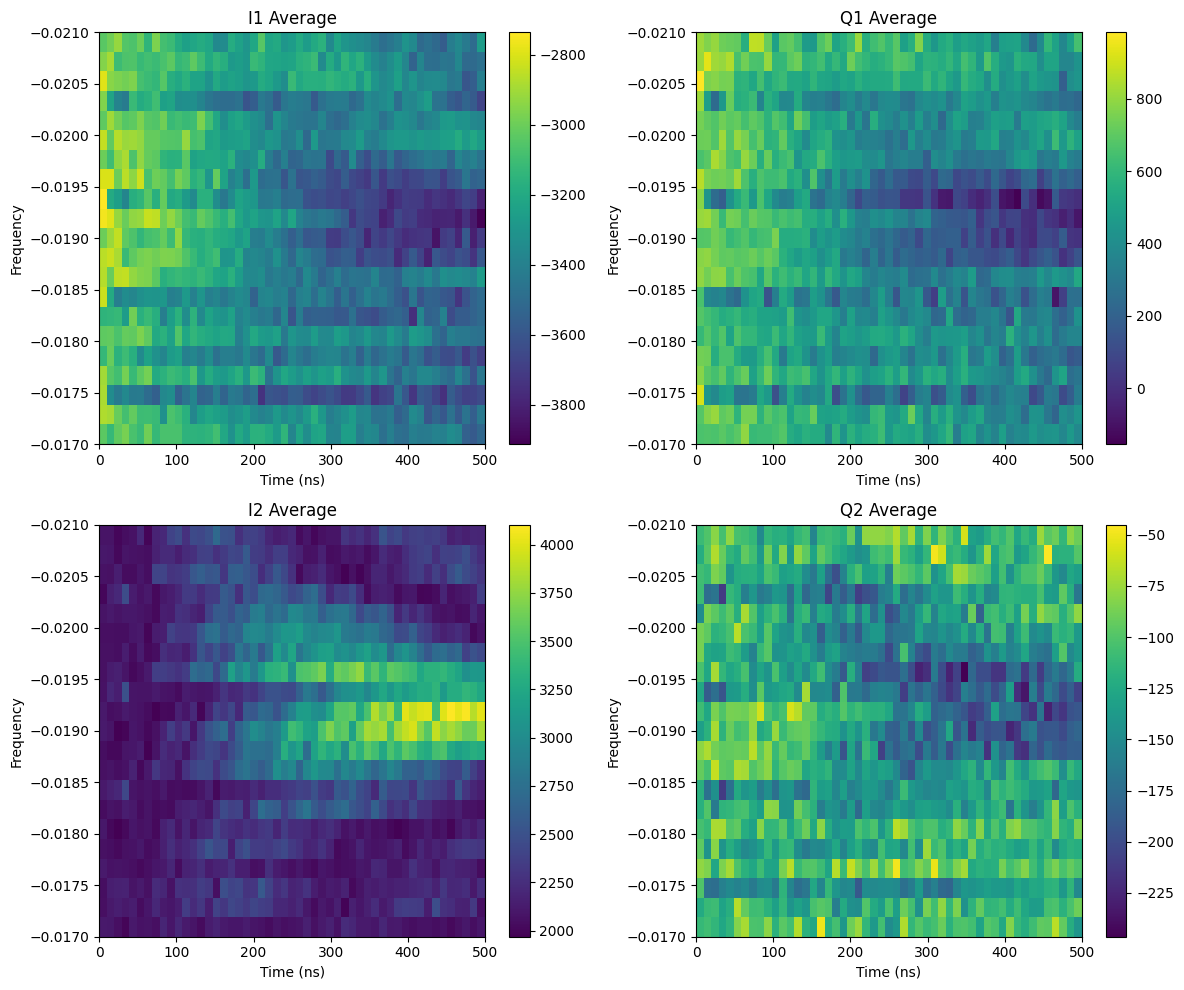

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot I1_data
im1 = axes[0, 0].imshow(I1_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[0, 0].set_title('I1 Average')
axes[0, 0].set_xlabel('Time (ns)')
axes[0, 0].set_ylabel('Frequency')
fig.colorbar(im1, ax=axes[0, 0])

# Plot Q1_data
im2 = axes[0, 1].imshow(Q1_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[0, 1].set_title('Q1 Average')
axes[0, 1].set_xlabel('Time (ns)')
axes[0, 1].set_ylabel('Frequency')
fig.colorbar(im2, ax=axes[0, 1])

# Plot I2_data
im3 = axes[1, 0].imshow(I2_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[1, 0].set_title('I2 Average')
axes[1, 0].set_xlabel('Time (ns)')
axes[1, 0].set_ylabel('Frequency')
fig.colorbar(im3, ax=axes[1, 0])

# Plot Q2_data
im4 = axes[1, 1].imshow(Q2_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[1, 1].set_title('Q2 Average')
axes[1, 1].set_xlabel('Time (ns)')
axes[1, 1].set_ylabel('Frequency')
fig.colorbar(im4, ax=axes[1, 1])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
max_index_I2_data = np.unravel_index(np.argmax(I2_data),I2_data.shape)
plt.imshow(I2_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
plt.axhline(y=freq_list[max_index_I2_data[0]],color='black', label = f'freq = {freq_list[max_index_I2_data[0]]:.4f}')
plt.legend()
plt.colorbar()
plt.show()

In [6]:
max_index_I1_data = np.unravel_index(np.argmin(I1_data),Q1_data.shape)
plt.imshow(I1_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
plt.axhline(y=freq_list[max_index_I1_data[0]],color='black', label = f'freq = {freq_list[max_index_I1_data[0]]:.4f}')
plt.legend()
plt.colorbar()
plt.show()

NameError: name 'I1_data' is not defined

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 1000
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.766815 sec
Captured 17 buffers (2.512260 buffers per sec)
Captured 52224 records (7717.663120 records per sec)
Transferred 855638016 bytes (126446192.564494 bytes per sec)


<Figure size 800x800 with 0 Axes>

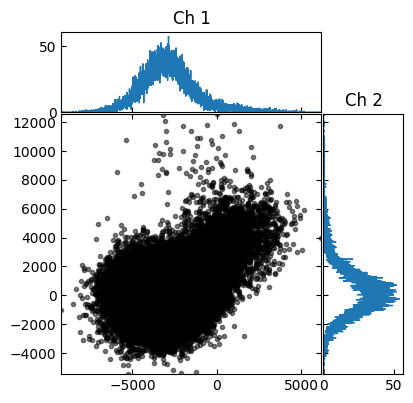

<Figure size 800x800 with 0 Axes>

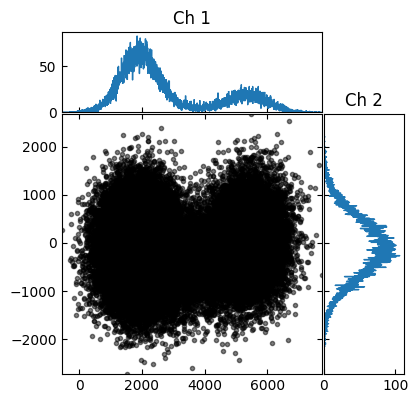

In [4]:
num_steps=51
reps=1000
frequency=-.0190
sweep_time =1000#0.5*num_steps/abs(frequency)#7
phase = 50
spec_amp=1.5
pmc.parametric_coupling_time_domain(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            ssm_para=frequency,
            spec_amp=spec_amp,
            sweep_time=sweep_time,
            phase=phase,
            verbose=False,
        )
wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
        # Acquire the raw IQ data
values = daq.run_daq_het_2q(
            q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
        )

In [5]:
IQ_df = plotting.get_IQ_averages(values)
print(IQ_df['I1'])
# print(IQ_df['I2'])

0    -2322.817812
1    -2299.130578
2    -2454.350454
3    -2589.919661
4    -2479.137961
5    -2454.351015
6    -2686.772870
7    -2638.242391
8    -2669.539560
9    -2738.845607
10   -2827.603428
11   -2807.227381
12   -3009.298388
13   -2976.766381
14   -2953.040371
15   -3014.629813
16   -3088.584356
17   -3136.791444
18   -3112.494719
19   -3135.940827
20   -3232.430985
21   -3168.175287
22   -3216.987028
23   -3210.020353
24   -3145.326526
25   -3210.216199
26   -3140.008868
27   -3135.426101
28   -2973.318777
29   -3009.285932
30   -2966.637559
31   -3012.884329
32   -3020.983461
33   -2879.540389
34   -2807.128703
35   -2822.489686
36   -2826.517101
37   -2801.496891
38   -2891.081495
39   -2752.279014
40   -2817.695615
41   -2767.507392
42   -2880.366901
43   -2851.133528
44   -2844.092329
45   -2864.649837
46   -2855.455950
47   -2909.222136
48   -2877.129872
49   -2963.271618
50   -2917.797319
Name: I1, dtype: float64


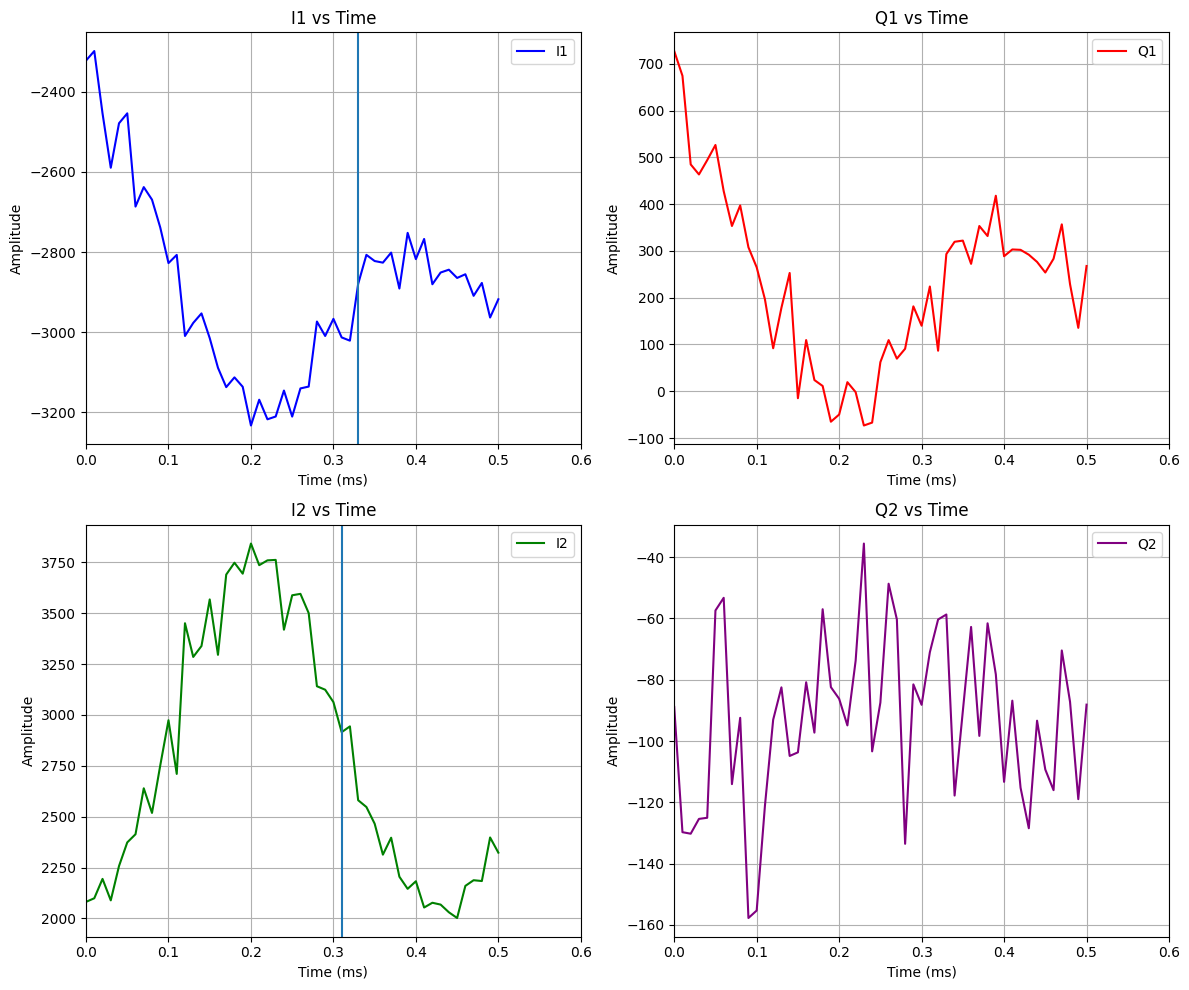

In [8]:
times = np.linspace(0, sweep_time / 1000, num_steps)  # x-axis values in milliseconds
IQ_df = plotting.get_IQ_averages(values)
# Create the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot I1
axes[0, 0].plot(times, IQ_df['I1'], color='blue', label='I1')
axes[0, 0].set_title('I1 vs Time')
axes[0, 0].set_xlabel('Time (ms)')
axes[0, 0].set_ylabel('Amplitude')
axes[0,0].set_xlim([0,0.6])
axes[0, 0].grid(True)
axes[0, 0].legend()
axes[0, 0].axvline(330/1000)

# Plot Q1
axes[0, 1].plot(times, IQ_df['Q1'], color='red', label='Q1')
axes[0, 1].set_title('Q1 vs Time')
axes[0, 1].set_xlabel('Time (ms)')
axes[0, 1].set_ylabel('Amplitude')
axes[0,1].set_xlim([0,0.6])
axes[0, 1].grid(True)
axes[0, 1].legend()

# Plot I2
axes[1, 0].plot(times, IQ_df['I2'], color='green', label='I2')
axes[1, 0].set_title('I2 vs Time')
axes[1, 0].set_xlabel('Time (ms)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True)
axes[1,0].set_xlim([0,0.6])
axes[1, 0].legend()
axes[1, 0].axvline(310/1000)

# Plot Q2
axes[1, 1].plot(times, IQ_df['Q2'], color='purple', label='Q2')
axes[1, 1].set_title('Q2 vs Time')
axes[1, 1].set_xlabel('Time (ms)')
axes[1, 1].set_ylabel('Amplitude')
axes[1,1].set_xlim([0,0.6])
axes[1, 1].grid(True)
axes[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

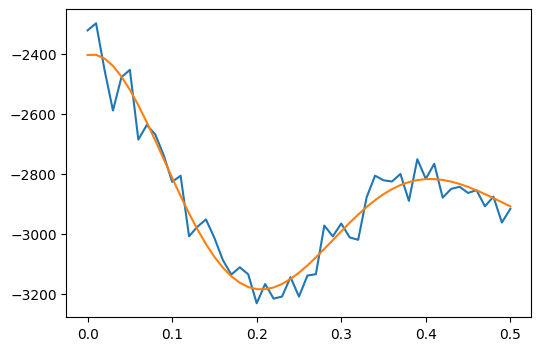



  freq: 2.502143045005249 +/- 0.07986407717840813
 gamma: 3.7786208685120424 +/- 0.32962505857176266
   amp: 559.9803344538964 +/- 27.55765585858288
 phase: 71.42561223686087 +/- 5.332383163414527
offset: -2935.845227268307 +/- 9.29570897290394
pi_pulse time: 0.19982870323824795 +/- 0.07986407717840813
π_ge time = 199.82870323824795 ns


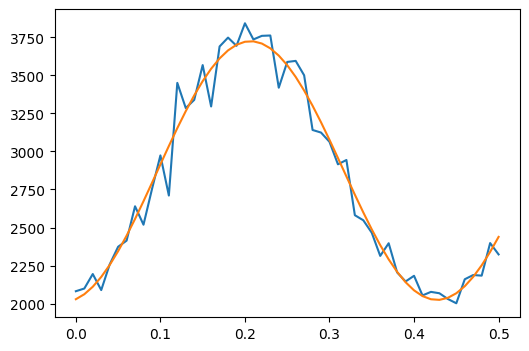



  freq: 2.2657962775809923 +/- 0.04051297832792342
 gamma: 0.03313030822281922 +/- 0.20744801395379625
   amp: -859.368708636194 +/- 50.39154657161037
 phase: 101.3536431908552 +/- 3.8792312402510314
offset: 2871.340368839872 +/- 20.40929442965168
pi_pulse time: 0.22067297265304434 +/- 0.04051297832792342
π_ge time = 220.67297265304433 ns


In [7]:
sweep_time=500
I1 = IQ_df['I1']
I2 = IQ_df['I2']
Q1 = IQ_df['Q1']
Q2= IQ_df['Q2']
Qrange1 = abs(np.max(Q1)-np.min(Q1))
Irange1 = abs(np.max(I1)-np.min(I1))
if Qrange1>Irange1:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q1,guess_vals=[3.4542658570,0.3,np.abs(np.max(Q1)-np.min(Q1)),38,Q1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I1,guess_vals=[3.4542658570,0.3,np.abs(np.max(I1)-np.min(I1)),38,I1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
Qrange2 = abs(np.max(Q2)-np.min(Q2))
Irange2 = abs(np.max(I2)-np.min(I2))
if Qrange2>Irange2:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q2,guess_vals=[11,0.3,np.abs(np.max(Q2)-np.min(Q2)),38,Q1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I2,guess_vals=[11,0.3,np.abs(np.max(I2)-np.min(I2)),38,I1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))